In [21]:
import sys  
sys.path.insert(0, './')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [22]:
# Filtered to just Bananas
df = pd.read_csv('../tutorial/tutorial.csv', index_col='timestamp', delimiter=';')
df = df.loc[df['product']=='BANANAS']
df = df[['mid_price']]
df.head()

,mid_price
timestamp,
0,4949.0
100,4947.5
200,4948.0
300,4948.5
400,4949.0


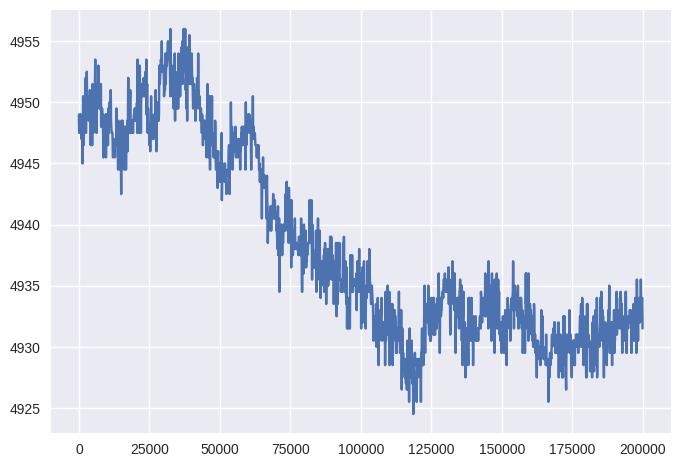

In [23]:
plt.plot(df)

# ARIMA Model

## AR

In [24]:
def ar_process(eps, phi):
    """
    Creates a AR process with a zero mean.
    """
    # Reverse the order of phi and add a 1 for current eps_t
    phi = np.r_[1, phi][::-1]
    ar = eps.copy()
    offset = len(phi)
    for i in range(offset, ar.shape[0]):
        ar[i - 1] = ar[i - offset: i] @ phi
    return ar

## MA

In [25]:
n = 500
eps = np.random.normal(size=n)


def lag_view(x, order):
    """
    For every value X_i create a row that lags k values: [X_i-1, X_i-2, ... X_i-k]
    """
    y = x.copy()
    # Create features by shifting the window of `order` size by one step.
    # This results in a 2D array [[t1, t2, t3], [t2, t3, t4], ... [t_k-2, t_k-1, t_k]]
    x = np.array([y[-(i + order):][:order] for i in range(y.shape[0])])

    # Reverse the array as we started at the end and remove duplicates.
    # Note that we truncate the features [order -1:] and the labels [order]
    # This is the shifting of the features with one time step compared to the labels
    x = np.stack(x)[::-1][order - 1: -1]
    y = y[order:]

    return x, y

def ma_process(eps, theta):
    """
    Creates an MA(q) process with a zero mean (mean not included in implementation).
    :param eps: (array) White noise signal.
    :param theta: (array/ list) Parameters of the process.
    """
    # reverse the order of theta as Xt, Xt-1, Xt-k in an array is Xt-k, Xt-1, Xt.
    theta = np.array([1] + list(theta))[::-1][:, None]
    eps_q, _ = lag_view(eps, len(theta))
    return eps_q @ theta

## Differencing

In [26]:

def difference(x, d=1):
    return np.diff(x, d)

def undo_difference(x, x_diff):
    return np.concatenate(([x[0]], x_diff)).cumsum()

## Main Class

In [27]:
def least_squares(x, y):
    if np.linalg.det(x.T @ x) != 0:
        return np.linalg.inv((x.T @ x)) @ (x.T @ y)
    return np.linalg.pinv((x.T @ x)) @ (x.T @ y) 

class LinearModel:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.beta = None
        self.intercept_ = None
        self.coef_ = None

    def _prepare_features(self, x):
        if self.fit_intercept:
            x = np.hstack((np.ones((x.shape[0], 1)), x))
        return x

    def fit(self, x, y):
        x = self._prepare_features(x)
        self.beta = least_squares(x, y)
        if self.fit_intercept:
            self.intercept_ = self.beta[0]
            self.coef_ = self.beta[1:]
        else:
            self.coef_ = self.beta

    def predict(self, x):
        x = self._prepare_features(x)
        return x @ self.beta

    def fit_predict(self, x, y):
        self.fit(x, y)
        return self.predict(x)


class ARIMA(LinearModel):
    def __init__(self, p, d, q):
        """
        An ARIMA model.
        :param q: (int) Order of the MA model.
        :param p: (int) Order of the AR model.
        :param d: (int) Number of times the data needs to be differenced.
        """
        super().__init__(True)
        self.p = p
        self.d = d
        self.q = q
        self.ar = None
        self.resid = None

    def prepare_features(self, x):
        if self.d > 0:
            x = difference(x, self.d)

        ar_features = None
        ma_features = None

        # Determine the features and the epsilon terms for the MA process
        if self.q > 0:
            if self.ar is None:
                self.ar = ARIMA(self.p, 0, 0)
                self.ar.fit_predict(x)
            eps = self.ar.resid
            eps[0] = 0

            # prepend with zeros as there are no residuals_t-k in the first X_t
            ma_features, _ = lag_view(np.r_[np.zeros(self.q), eps], self.q)

        # self.p = 1
        # Determine the features for the AR process
        if self.p > 0:
            # prepend with zeros as there are no X_t-k in the first X_t
            ar_features = lag_view(np.r_[np.zeros(self.p), x], self.p)[0]

        if ar_features is not None and ma_features is not None:
            n = min(len(ar_features), len(ma_features))
            ar_features = ar_features[:n]
            ma_features = ma_features[:n]
            features = np.hstack((ar_features, ma_features))
        elif ma_features is not None:
            n = len(ma_features)
            features = ma_features[:n]
        else:
            n = len(ar_features)
            features = ar_features[:n]

        return features, x[:n]

    def fit(self, x):
        features, x = self.prepare_features(x)
        super().fit(features, x)
        return features

    def fit_predict(self, x):
        """
        Fit and transform input
        :param x: (array) with time series.
        """
        features = self.fit(x)
        return self.predict(x, prepared=(features))

    def predict(self, x, **kwargs):
        """
        :param x: (array)
        :kwargs:
            prepared: (tpl) containing the features, eps and x
        """
        features = kwargs.get('prepared', None)
        if features is None:
            features, x = self.prepare_features(x)

        y = super().predict(features)
        self.resid = x - y

        return self.return_output(y)

    def return_output(self, x):
        if self.d > 0:
            x = undo_difference(x, self.d)
        return x

    def forecast(self, x, n):
        """
        Forecast the time series.
        :param x: (array) Current time steps.
        :param n: (int) Number of time steps in the future.
        """
        features, x = self.prepare_features(x)
        y = super().predict(features)

        # Append n time steps as zeros. Because the epsilon terms are unknown
        y = np.r_[y, np.zeros(n)]
        for i in range(n):
            feat = np.r_[y[-(self.p + n) + i: -n + i], np.zeros(self.q)]
            y[x.shape[0] + i] = super().predict(feat[None, :])
        return self.return_output(y)

In [28]:
m = ARIMA(1,1,1)
window = 100
df_prices = df['mid_price'].to_numpy()
# print(df_prices[:-1])
# appended = np.concatenate(([df_prices[0]],df_prices[:window]))

x = difference(df_prices[:window])
pred = m.fit_predict(x)
forec = m.forecast(pred,1)
# plt.plot(df_prices)
# plt.scatter(range(0,pred.size),pred, marker ="o", alpha=0.5, edgecolor ="red", c="red", s=10)
# plt.show()

ValueError: operands could not be broadcast together with shapes (99,) (98,) 

In [ ]:
print(undo_difference(df_prices[:window], forec))

[4949.         4949.0044339  4949.00946663 4949.06171846 4948.60470834
 4948.07263099 4948.20993439 4948.69731015 4948.21814839 4948.88733
 4949.70601131 4949.93376393 4949.94894675 4949.275982   4950.93046795
 4949.93142512 4947.31677302 4947.99885919 4949.78069318 4948.72259987
 4948.23482581 4948.98182471 4948.67769913 4948.36157641 4947.98576842
 4945.79900597 4947.73865153 4947.85903076 4946.98951297 4945.06237366
 4946.17298426 4947.12578329 4946.90010978 4947.39087038 4947.38390155
 4947.24281501 4947.88984497 4946.89757182 4946.9007575  4946.83748825
 4946.02702094 4946.32397855 4946.96762368 4949.18475177 4948.57669976
 4947.47584537 4947.20339115 4947.18104035 4949.18559865 4946.88532792
 4946.91743492 4946.93198296 4948.34561257 4947.50622394 4946.38660274
 4946.78352929 4946.44187008 4946.46043774 4945.25559479 4943.56656176
 4944.97094428 4946.29596731 4946.91471074 4948.44369126 4949.1590188
 4947.22235977 4946.16855872 4945.3829931  4945.36402714 4945.49794571
 4944.1743

In [ ]:
df_prices[:(window+1)]

array([4949. , 4947.5, 4948. , 4948.5, 4949. , 4948.5, 4948. , 4949. ,
       4947.5, 4947. , 4947. , 4947. , 4948. , 4945. , 4948. , 4950.5,
       4948. , 4946.5, 4949. , 4948.5, 4947.5, 4948.5, 4948.5, 4949. ,
       4952. , 4947.5, 4949.5, 4950. , 4952.5, 4949.5, 4949.5, 4950. ,
       4949. , 4949.5, 4949.5, 4948.5, 4950.5, 4949.5, 4950. , 4951. ,
       4950. , 4949.5, 4946.5, 4949. , 4949.5, 4949.5, 4949.5, 4946.5,
       4951.5, 4949. , 4950. , 4947.5, 4950. , 4950.5, 4949.5, 4950.5,
       4950. , 4952. , 4953.5, 4950.5, 4950. , 4949.5, 4947.5, 4947.5,
       4950.5, 4950.5, 4951.5, 4951. , 4951. , 4953. , 4951. , 4950.5,
       4950.5, 4949.5, 4950. , 4950. , 4949.5, 4951.5, 4951.5, 4948. ,
       4948.5, 4948.5, 4949.5, 4949. , 4948. , 4949. , 4947.5, 4945.5,
       4946. , 4948.5, 4947.5, 4947.5, 4947.5, 4948.5, 4949. , 4949. ,
       4945.5, 4949. , 4947.5, 4948.5, 4949. ])

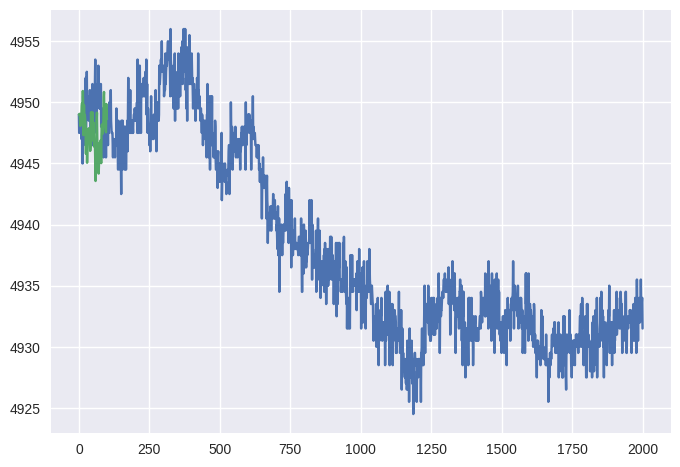

In [ ]:
plt.plot(df_prices)
plt.plot(undo_difference(np.concatenate(([df_prices[0]],df_prices[:window])), forec))

In [ ]:
class ARIMA:
    def __init__(self, p, d, q):
        self.p = p # AR order
        self.d = d # differencing order
        self.q = q # MA order
        
        self.coeffs = None # coefficients of the model
        self.residuals = None # residuals of the model
        
    def fit(self, data):
        # Perform differencing
        diff_data = np.diff(data, n=self.d)
        
        # Initialize variables
        n = len(diff_data)
        y = diff_data[self.p:]
        X = np.zeros((n - self.p, self.p + self.q))
        
        # Populate X matrix with lags of y and errors
        for i in range(self.p):
            X[:, i] = diff_data[self.p - 1 - i:n - 1 - i]
        for i in range(self.q):
            X[:, self.p + i] = self.residuals[self.p - 1 - i:n - 1 - i]
        
        # Compute coefficients using least squares regression
        self.coeffs = np.linalg.lstsq(X, y, rcond=None)[0]
        
        # Compute residuals
        self.residuals = np.zeros(n - self.p)
        self.residuals[0] = diff_data[self.p] - X[0, :].dot(self.coeffs)
        for i in range(1, n - self.p):
            self.residuals[i] = diff_data[self.p + i] - X[i, :].dot(self.coeffs)
        
    def predict(self, n):
        # Predict n future values
        pred = np.zeros(n)
        for i in range(n):
            # Compute next value using the model coefficients and previous residuals
            prev_vals = np.concatenate((self.residuals[-self.p:], pred[:i]))
            pred[i] = self.coeffs[:self.p].dot(prev_vals) + self.coeffs[self.p:].dot(self.residuals[-self.q:])
        
        # Perform inverse differencing
        for i in range(1, self.d + 1):
            pred = np.concatenate(([pred[0]], np.cumsum(pred)[i:] - np.cumsum(pred)[:-i]))
            
        return pred


In [ ]:
m = ARIMA(1,1,1)
window = 100
df_prices = df['mid_price'].to_numpy()
# print(df_prices[:-1])
# appended = np.concatenate(([df_prices[0]],df_prices[:window]))
m.fit(df_prices[:window])
forec = m.predict(1)
# plt.plot(df_prices)
# plt.scatter(range(0,pred.size),pred, marker ="o", alpha=0.5, edgecolor ="red", c="red", s=10)
# plt.show()

NameError: name 'df' is not defined